In [160]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [68]:
df = pd.read_csv("Data/Aviation_Data.csv")

/var/folders/ym/68nrz1n97wj0gz5413bhpqs80000gn/T/ipykernel_3891/2459307861.py:1: DtypeWarning: Columns (6,7,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("Data/Aviation_Data.csv")


To Do:
- check normalizing and filtering
- table - incidents and total deaths
- add produced airplanes
- ratios
- show over time


In [4]:
pd.options.display.max_rows = 100

In [108]:
def normalize(name, normalized_names):
    for x in normalized_names:
        if x.lower() in str(name).lower():
            return x
    return name

#manufacturers = {"Boeing":"", "Airbus":"Airbus", "Comac":"Comac", "Embraer":"Embraer", 
#"Havilland":"de Havilland", "Britten":"Britten-Norman", "Evektor":"Evektor", "Cessna":"Cessna", "Texas Aircraft":"Texas Aircraft", "Piper":"Piper",
#"Cubcrafters":"Cubcrafters","Beechcraft":"Beechcraft","Diamond":"Diamond",
#"Cirrus":"Cirrus","Bombardier":"Bombardier"}
                        
models_of_interest = pd.DataFrame([["Boeing","737",11762], ["Boeing","767",1311], ["Airbus","A320",11471], ["Airbus","A340", 380], 
["Boeing",'777',1729], ["Airbus","A319",1501], ["Airbus",'A330',1601], ["Airbus","A321",3145],
["Boeing","787",1129], ["Airbus","A350",602], ["Airbus",'A220',335]],columns=["Make","Model","Produced"])

df["Make"]=df["Make"].map(lambda x:str(x))
df.loc["Model"]=df["Model"].map(lambda x:str(x))

df["Make"] = df["Make"].map(lambda x:normalize(x,models_of_interest["Make"].unique()))
df["Model"] = df["Model"].map(lambda x:normalize(x,models_of_interest["Model"].unique()))

df.to_csv("test.csv")

models_of_interest["Make"].unique()


array(['Boeing', 'Airbus'], dtype=object)

In [136]:
filter = df["Make"].map(lambda x:x in models_of_interest["Make"].unique())
df = df[filter]

filter = df["Model"].map(lambda x:x in models_of_interest["Model"].unique())
df = df[filter]

#df[df["Make"]=="Airbus"]


for col in ["Total.Serious.Injuries","Total.Fatal.Injuries"]:
    df[col]=df[col].map(lambda x:0 if np.isnan(x) else int(x))

incidents = df.groupby(["Make","Model"]).count()["Total.Serious.Injuries"]
incidents_injuries=df[df["Total.Serious.Injuries"]>0].groupby(["Make","Model"]).count()["Total.Serious.Injuries"]

incidents_fatal=df[df["Total.Fatal.Injuries"]>0].groupby(["Make","Model"]).count()["Total.Fatal.Injuries"]
injury_total=df.groupby(["Make","Model"]).sum()[["Total.Serious.Injuries","Total.Fatal.Injuries"]]


In [188]:
modelCompare=pd.concat([incidents,incidents_injuries,incidents_fatal,injury_total],axis=1)
modelCompare.columns=["Incidents-Any","Incidents-Injuries","Incidents-Fatalities","Total Injuries","Total Fatalities"]

for col in modelCompare.columns:
    modelCompare[col]=modelCompare[col].map(lambda x: 0 if np.isnan(x) else int(x))


produced = models_of_interest.set_index(["Make","Model"])
modelCompare = modelCompare.sort_values(["Make","Model"])
modelCompare = pd.concat([modelCompare,produced], axis=1)


Incidents-Any  Incidents-Injuries  Incidents-Fatalities  \
Make   Model                                                            
Airbus A220               5                   0                     0   
       A319              52                  15                     0   
       A320             152                  17                    10   
       A321              36                   2                     2   
       A330              63                   6                     2   
       A340               5                   1                     0   
       A350               2                   0                     1   
Boeing 737             1040                 148                    60   
       767              213                  48                     6   
       777              165                  26                     4   
       787               42                   4                     0   

              Total Injuries  Total Fatalities  Produced  
Make   Model                                              
Airbus A220                0                 0       335  
       A319               62                 0      1501  
       A320               96              1027     11471  
       A321                9               381      3145  
       A330               36               331      1601  
       A340                2                 0       380  
       A350                0                 1       602  
Boeing 737              1038              3897     11762  
       767               251               640      1311  
       777               221               538      1729  
       787                12                 0      1129

In [155]:
modelCompare["IncidentsRatio"]=modelCompare["Incidents-Any"]/modelCompare["Produced"]
modelCompare["IncidentsFatalitiesRatio"]=modelCompare["Incidents-Fatalities"]/modelCompare["Produced"]
modelCompare["IncidentsInjuriesRatio"]=modelCompare["Incidents-Injuries"]/modelCompare["Produced"]

In [190]:
modelCompare[["Incidents-Any","Incidents-Injuries"]]

Incidents-Any  Incidents-Injuries
Make   Model                                   
Airbus A220               5                   0
       A319              52                  15
       A320             152                  17
       A321              36                   2
       A330              63                   6
       A340               5                   1
       A350               2                   0
Boeing 737             1040                 148
       767              213                  48
       777              165                  26
       787               42                   4

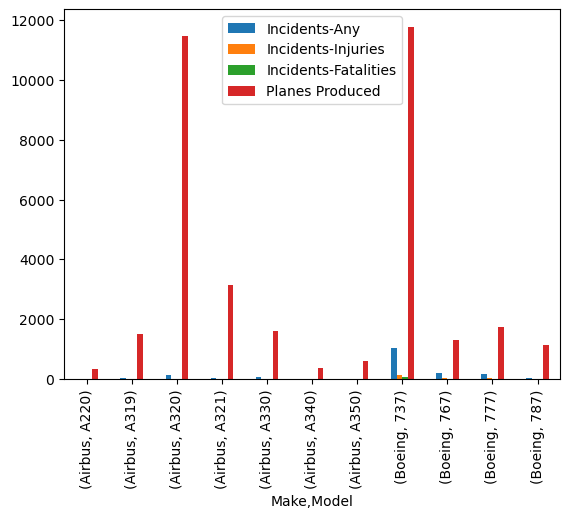

In [185]:
fig, ax = plt.subplots()
modelCompare.plot.bar(y=["Incidents-Any","Incidents-Injuries","Incidents-Fatalities","Produced"], ax=ax)
ax.legend(["Incidents-Any","Incidents-Injuries","Incidents-Fatalities","Planes Produced"])


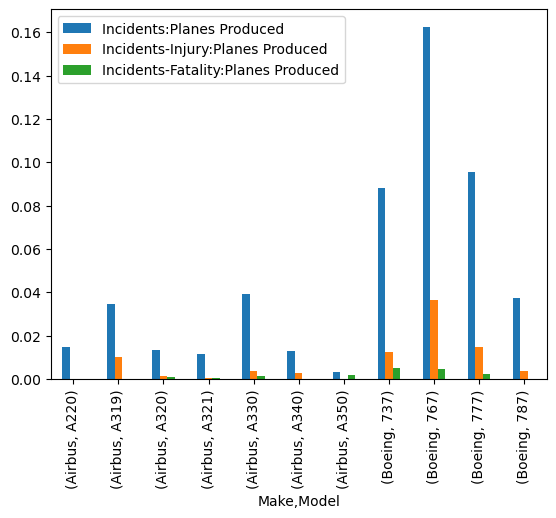

In [183]:
fig, ax = plt.subplots()
modelCompare.plot.bar(y=["IncidentsRatio","IncidentsInjuriesRatio","IncidentsFatalitiesRatio"], ax=ax)
ax.legend(["Incidents:Planes Produced","Incidents-Injury:Planes Produced","Incidents-Fatality:Planes Produced"])

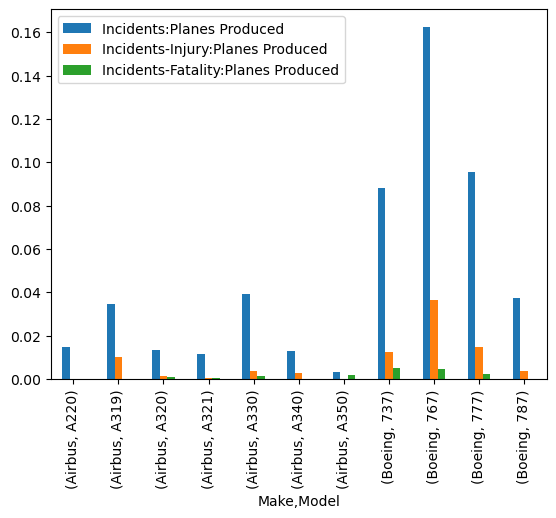

In [168]:
fig, ax = plt.subplots()
modelCompare.plot.bar(y=["IncidentsRatio","IncidentsInjuriesRatio","IncidentsFatalitiesRatio"], ax=ax)
ax.legend(["Incidents:Planes Produced","Incidents-Injury:Planes Produced","Incidents-Fatality:Planes Produced"])

<Axes: xlabel='Make,Model'>

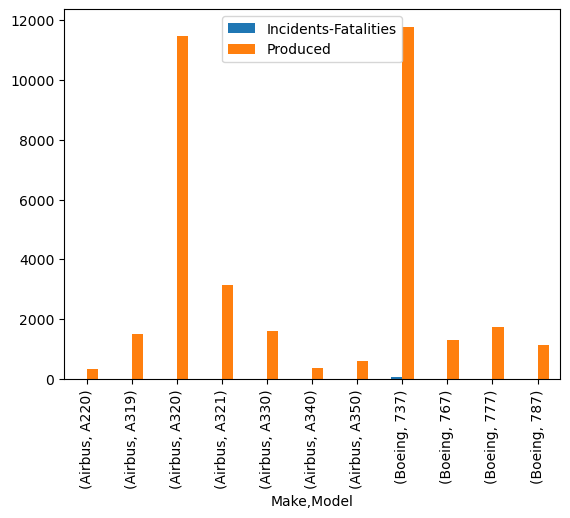

In [141]:
modelCompare.plot.bar(y=["Incidents-Fatalities","Produced"])

In [57]:
df[df["Model"]=="A319"][["Total.Serious.Injuries","Total.Fatal.Injuries"]]

,Total.Serious.Injuries,Total.Fatal.Injuries
51714,NaN,NaN
52429,1.0,NaN
53832,NaN,NaN
54418,1.0,NaN
54751,1.0,NaN
56951,NaN,NaN
57085,1.0,NaN
59686,NaN,NaN
60156,NaN,NaN
60996,1.0,NaN


In [81]:
df = df[df["Make"].map(lambda x: x in list(manufacturers.keys()))]

In [74]:
df["Model"] = df["Model"].map(lambda x:str(x))

In [82]:
df.groupby(["Make","Model"]).count()

Event.Id  Investigation.Type  Accident.Number  \
Make   Model                                                                 
Airbus 220                          1                   1                1   
       300-200                      1                   1                1   
       300-600                      1                   1                1   
       300B4-200                    1                   1                1   
       319                          3                   3                3   
...                               ...                 ...              ...   
Piper  Saratoga II TC PA32-         1                   1                1   
       Seneca                       2                   2                2   
       TG8-J3C-65                   1                   1                1   
       TITAN TORNADO II D           1                   1                1   
       nan                          1                   1                1   

                             Event.Date  Location  Country  Latitude  \
Make   Model                                                           
Airbus 220                            1         1        1         0   
       300-200                        1         1        1         0   
       300-600                        1         1        1         0   
       300B4-200                      1         1        1         0   
       319                            3         3        3         2   
...                                 ...       ...      ...       ...   
Piper  Saratoga II TC PA32-           1         1        1         1   
       Seneca                         2         2        2         2   
       TG8-J3C-65                     1         1        1         0   
       TITAN TORNADO II D             1         1        1         1   
       nan                            1         1        1         1   

                             Longitude  Airport.Code  Airport.Name  ...  \
Make   Model                                                        ...   
Airbus 220                           0             0             0  ...   
       300-200                       0             0             0  ...   
       300-600                       0             0             0  ...   
       300B4-200                     0             1             1  ...   
       319                           2             1             1  ...   
...                                ...           ...           ...  ...   
Piper  Saratoga II TC PA32-          1             0             0  ...   
       Seneca                        2             1             1  ...   
       TG8-J3C-65                    0             0             1  ...   
       TITAN TORNADO II D            1             1             1  ...   
       nan                           1             0             0  ...   

                             Purpose.of.flight  Air.carrier  \
Make   Model                                                  
Airbus 220                                   0            1   
       300-200                               1            0   
       300-600                               1            1   
       300B4-200                             0            0   
       319                                   1            1   
...                                        ...          ...   
Piper  Saratoga II TC PA32-                  1            0   
       Seneca                                2            1   
       TG8-J3C-65                            1            0   
       TITAN TORNADO II D                    1            1   
       nan                                   1            1   

                             Total.Fatal.Injuries  Total.Serious.Injuries  \
Make   Model                                                                
Airbus 220                                      1                       1   
       300-200                                  1 

In [151]:
planesAirbus = {"220":"A220","320":"A320","330":"A330","A-320":"A320","A-340":"A340","319":"A319",
          "A321":"A321","A340":"A340","AS350":"A350"}

#.map(lambda x:normalize(x,planes))
df.loc[df["Make"]=="Airbus","Model"]=df[df["Make"]=="Airbus"]["Model"].map(lambda x:normalize(x,planes))

In [152]:
df.loc[df["Make"]=="Airbus","Model"] = df.loc[df["Make"]=="Airbus","Model"].map(lambda x:normalize(x,planes))

In [123]:
df.groupby(["Make","Model"]).count().loc["Boeing"].head(100)

,Event.Id,Investigation.Type,Accident.Number,Event.Date,Location,Country,Latitude,Longitude,Airport.Code,Airport.Name,...,Purpose.of.flight,Air.carrier,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Weather.Condition,Broad.phase.of.flight,Report.Status,Publication.Date
Model,,,,,,,,,,,,,,,,,,,,,
-737-222,1,1,1,1,1,1,0,0,1,1,...,1,0,1,1,1,1,1,0,1,1
107,1,1,1,1,1,1,0,0,0,0,...,1,0,1,1,1,1,1,1,1,1
107-11,1,1,1,1,1,1,0,0,0,0,...,1,0,1,1,1,1,1,0,1,1
1942,1,1,1,1,1,1,1,1,0,0,...,1,0,0,0,0,1,1,1,1,1
1B75A,1,1,1,1,1,1,0,0,1,1,...,1,0,1,1,1,1,1,1,1,1
234,3,3,3,3,3,3,1,1,0,1,...,3,1,2,2,2,2,2,0,2,3
234ER,1,1,1,1,1,1,0,0,0,0,...,1,0,1,1,1,1,1,1,1,0
2X6C,1,1,1,1,1,1,0,0,0,0,...,0,0,1,1,1,1,0,0,0,0
300,1,1,1,1,1,1,0,0,0,0,...,0,1,1,1,1,1,0,0,0,1


In [126]:
planesBoeing = {"737":"737", "767":"767", "777":"777", "787":"787"}
df.loc[df["Make"]=="Boeing","Model"] = df[df["Make"]=="Boeing"]["Model"].map(lambda x:normalize(x,planesBoeing))

In [153]:
filter = df["Model"].map(lambda x:x in list(planesBoeing.values())+list(planesAirbus.values()))

In [154]:
df=df[filter]

In [165]:
df["Model"].unique()

array(['737', '767', 'A320', 'A340', '777', 'A319', 'A330', 'A321', '787',
       'A350', 'A220'], dtype=object)

In [182]:
airplanes_produced = {'737':11762, '767':1311, 'A320':11471, 'A340':380, '777':1729, 'A319':1501, 'A330':1601, 'A321':3145, '787':1129,
       'A350':602, 'A220':335}

In [195]:
grouped = df.groupby(["Make","Model"]).sum()
grouped.reset_index(inplace=True)
grouped.set_index("Model",inplace=True)
pd.Series(airplanes_produced)

#pd.concat(grouped,pd.DataFrame(airplanes_produced),axis=1)

737     11762
767      1311
A320    11471
A340      380
777      1729
A319     1501
A330     1601
A321     3145
787      1129
A350      602
A220      335
dtype: int64

In [193]:
pd.concat([grouped,temp],axis=1)

,Make,Event.Id,Investigation.Type,Accident.Number,Event.Date,Location,Country,Latitude,Longitude,Airport.Code,...,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Weather.Condition,Broad.phase.of.flight,Report.Status,Publication.Date,Model,Number
A220,Airbus,20181228X6401520190801X0445620190917X927182020...,IncidentIncidentIncidentIncidentIncidentAccident,ENG19IA008ENG19IA029ENG19IA034ENG20LA015DCA21W...,2018-12-262019-07-252019-09-162020-02-122021-0...,"Busan, South KoreaPerrigny-sur-Armancon, Franc...",South KoreaFranceFranceFranceDenmarkUnited States,474124N,0041419E,CDG,...,0.0,0.0,1.0,469.0,VMC,0,A No. 1 (left) engine low pressure compressor ...,25-09-202026-09-202012-05-202111-09-2022,NaN,NaN
A319,Airbus,20010108X0006020001212X1987120011109X022192002...,IncidentAccidentIncidentAccidentIncidentAccide...,DCA98WA083NYC99LA240FTW02IA027LAX02LA138CHI03I...,1998-08-281999-09-302001-11-022002-04-152002-1...,"CALCUTTA, IndiaSPARTA, NJMidland, TXReno, NVCh...",IndiaUnited StatesUnited StatesUnited StatesUn...,31.942539.48333341.97972338.28888939.86388927....,-102.201944-119.766667-87.904444-104.496666-10...,MAFRNOORDDENKTPAMHTMSPDENKORDLGADENDENDENKATLD...,...,0.0,77.0,28.0,5134.0,UNKVMCVMCVMCVMCVMCVMCVMCVMCVMCVMCVMCIMCVMCVMCV...,CruiseCruiseApproachTakeoffClimbDescentTaxiTax...,ForeignProbable CauseProbable CauseProbable Ca...,13-08-200103-12-200402-03-200428-04-200405-02-...,NaN,NaN
A320,Airbus,20001212X2396920001212X1810920001211X139752000...,IncidentIncidentAccidentIncidentIncidentAccide...,DCA90IA048LAX91IA415DCA92RA019CHI95IA138CHI95I...,1990-08-101991-09-201992-01-201995-04-271995-0...,"CHICAGO, ILSANTA ANA, CASTRASBURG, FranceWASHI...",United StatesUnited StatesFranceUnited StatesU...,40.63833342.212534.76583333.44027744.8834.2613...,-73.761667-83.338889-114.473889-112.002222-93....,SNADCAMSPDTWDENCMHPHXLASJFKDTWPHXDENDENKATLDEN...,...,1027.0,100.0,57.0,13593.0,VMCVMCIMCVMCVMCVMCVMCVMCIMCVMCVMCUNKVMCVMCVMCV...,UnknownLandingApproachCruiseTaxiClimbTakeoffLa...,Probable CauseProbable CauseForeignProbable Ca...,10-11-199408-02-199320-12-199429-04-199629-04-...,NaN,NaN
A321,Airbus,20051025X0171720090408X8035120100803X334172012...,AccidentIncidentAccidentAccidentIncidentIncide...,DCA05MA099ENG08WA048DCA10WA081DCA12FA046ENG12W...,2005-09-182008-03-302010-07-282012-02-242012-0...,"FORT LAUDERDALE, FLLahore, PakistanIslamabad, ...",United StatesPakistanPakistanUnited StatesViet...,039180N351249N026418N403839N028480N333858N4158...,0075318W0805657W0080859W0734714W0067360W084245...,FLLLHEOPRNCXRCLTFLLATLKORDDCALAXDFWJFKMCODSAMS...,...,381.0,9.0,8.0,3283.0,VMCIMCVMCVMCVMCVMCVMCVMCVMCVMCIMCVMCVMCVMCVMCVMC,Landing,Probable CauseThe accident is being investigat...,26-02-200703-11-202003-11-202025-09-202003-11-...,NaN,NaN
A330,Airbus,20040716X0098920020111X0006120030131X001372008...,IncidentIncidentIncidentIncidentIncidentIncide...,ENG01RA004DCA01WA062OPS03IA001ENG04RA001DCA04I...,2001-07-252001-08-242002-12-172003-08-092003-1...,"Brussels, BelgiumTerceira-Azores, PortugalAgan...",BelgiumPortugalUnited StatesBelgiumUnited Stat...,42.36416745.58861121.318611022140S025848N35124...,-71.005-122.5975-157.92250011450E0303524W08056...,PGUMMIABOSPDXDBXHNLHKGCLTBOSCCSJFKIADKCLTCDGHK...,...,331.0,46.0,42.0,8257.0,IMCVMCVMCVMCVMCVMCIMCVMCVMCVMCVMCVMCVMCUnkIMCV...,ApproachClimbTakeoffTaxiCruise,ForeignForeignProbable CauseForeignProbable Ca...,15-04-200811-01-200205-02-200406-05-200825-04-...,NaN,NaN
A340,Airbus,20001208X0598620020204X0017120050524X006572005...,AccidentIncidentIncidentAccidentAccident,FTW96LA269CHI01IA046BDCA04IA052DCA05RA088DCA06...,1996-06-212000-12-132004-06-072005-08-022005-1...,"DFW AIRPORT, TXChicago, ILWashington, DCToront...",United StatesUnited StatesUnited StatesCanadaU...,0,0,ORD,...,0.0,4.0,2.0,1089.0,VMCIMCVMC,ClimbTaxiStanding,Probable CauseProbable CauseProbable CauseFore...,31-03-199829-04-200330-11-200725-08-200506-12-...,NaN,NaN
A350,Airbus,20140409X3190720150313X7581320150703X008592

In [163]:
grouped = df.groupby(["Make","Model"]).sum()
results = grouped[["Total.Fatal.Injuries","Total.Serious.Injuries"]]
results.style.format(precision=0).format_index(str.upper, axis=1).relabel_index(["TOTAL FATALITIES","TOTAL INJURIES"],axis=1)

In [6]:
df["FAR.Description"].value_counts()

FAR.Description
091                               18221
Part 91: General Aviation          6486
NUSN                               1584
NUSC                               1013
137                                1010
135                                 746
121                                 679
Part 137: Agricultural              437
UNK                                 371
Part 135: Air Taxi & Commuter       298
PUBU                                253
129                                 246
Part 121: Air Carrier               165
133                                 107
Part 129: Foreign                   100
Non-U.S., Non-Commercial             97
Non-U.S., Commercial                 93
Part 133: Rotorcraft Ext. Load       32
Unknown                              22
Public Use                           19
091K                                 14
ARMF                                  8
Part 125: 20+ Pax,6000+ lbs           5
125                                   5
107                     

In [55]:
df["Make"]=df["Make"].map(lambda x:str(x))
df["Make"]=df["Make"].map(lambda x:x.lower())

In [76]:
df[df["Make"].str.contains("airbus")]["Make"].value_counts()

Make
airbus                            291
airbus industrie                  164
airbus helicopters                 13
airbus helicopters inc              3
airbus industries                   1
airbus/eurocopter                   1
airbus helicopter                   1
airbus helicopters (eurocopte       1
airbus helicopters deutschland      1
Name: count, dtype: int64

In [74]:
df["Make"]=df["Make"].map(lambda x: "boeing" if "boeing" in x else x)
df["Make"][df["Make"].str.contains("boeing")].value_counts()

Make
boeing    2833
Name: count, dtype: int64

In [81]:
df["Make"]=df["Make"].map(lambda x: "airbus" if "airbus" in x else x)

6737     airbus
11775    airbus
13699    airbus
15282    airbus
17123    airbus
18024    airbus
18297    airbus
19134    airbus
20367    airbus
21771    airbus
21901    airbus
21981    airbus
22921    airbus
22950    airbus
23477    airbus
26315    airbus
26334    airbus
28379    airbus
28951    airbus
29119    airbus
29555    airbus
29616    airbus
29755    airbus
34019    airbus
34253    airbus
34439    airbus
37169    airbus
37173    airbus
37389    airbus
37574    airbus
38971    airbus
39104    airbus
39251    airbus
39811    airbus
39876    airbus
40584    airbus
40934    airbus
41114    airbus
41233    airbus
41531    airbus
41760    airbus
42113    airbus
42548    airbus
42758    airbus
43160    airbus
43401    airbus
43402    airbus
43735    airbus
43872    airbus
44348    airbus
          ...  
86883    airbus
87004    airbus
87088    airbus
87122    airbus
87194    airbus
87202    airbus
87352    airbus
87375    airbus
87501    airbus
87672    airbus
87736    airbus
87791   

In [82]:
df["Make"].value_counts()

Make
cessna                            27149
piper                             14870
beech                              5372
boeing                             2833
bell                               2722
nan                                1522
mooney                             1334
robinson                           1230
grumman                            1172
bellanca                           1045
hughes                              932
schweizer                           773
air tractor                         691
aeronca                             636
mcdonnell douglas                   608
maule                               589
champion                            519
airbus                              476
stinson                             439
aero commander                      429
de havilland                        422
luscombe                            414
aerospatiale                        388
taylorcraft                         383
north american                     

In [101]:
df["Make"]=df["Make"].map(lambda x: "dornier" if "dornier" in x else x)

In [102]:
df[df["Make"].str.contains("dornier")]["Make"].value_counts()

Make
dornier    37
Name: count, dtype: int64

In [114]:
manufacturers = ["boeing","airbus","comac", "embraer", "de havilland", "britten-norman", "evektor", "cessna", "texas aircraft", "piper","cubcrafters","beechcraft","diamond","cirrus"]
filter = df["Make"].map(lambda x: x in manufacturers)
filtered_airplanes = df[filter]

In [115]:
filtered_airplanes["Make"].value_counts()

Make
cessna            27149
piper             14870
boeing             2833
de havilland        524
airbus              476
embraer             258
cirrus              150
britten-norman       57
diamond              49
beechcraft           30
cubcrafters           8
evektor               2
Name: count, dtype: int64

In [149]:
filtered_airplanes.groupby(["Make","Model"]).count().to_csv("test.csv")

AttributeError: 'DataFrame' object has no attribute 'unique'

In [162]:
pd.set_option("display.min_rows", 1000)

In [173]:
filtered_airplanes["Model_copy"] = filtered_airplanes["Model"].map(lambda x:str(x))

/var/folders/ym/68nrz1n97wj0gz5413bhpqs80000gn/T/ipykernel_2858/971976898.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_airplanes["Model_copy"] = filtered_airplanes["Model"].map(lambda x:str(x))


In [174]:
filtered_airplanes["Model_copy"]

1          PA24-180
2              172M
4               501
6               180
7               140
8              401B
10        PA-28-161
13            R172K
17              180
18              172
20              152
21             150L
23        PA-24-180
25             414A
26            BE-58
28             210L
30              182
32        PA-28-161
33       PA-34-200T
34            T337G
35       PA-28R-200
36              206
38            PA-22
39            PA-31
41        PA-24-250
42       PA-28R-200
43            TR182
44            A185F
45              340
48              152
50              A75
51              210
54             172M
55        PA-28-140
56           TU206G
57              152
58        PA-24-250
59              152
60             172N
61              152
63            P210N
64              172
65            PA-34
66       305 (L-19)
67             182A
68        PA-23-250
69             172N
70           23-250
72           TU206F
74             U206


In [190]:
airplane_family={"220":"a220","300":"a300","320":"a320","310":"a310","340":"a340",
                "319":"a319","321":"a321","330":"a330","350":"a350","380":"a380",
                "707":"707","717":"717","727":"727","737":"737","747":"747",
                 "757":"757","767":"767","777":"777","787":"787"}
for key in list(airplane_family.keys()):
    filtered_airplanes["Model_copy"]=filtered_airplanes["Model_copy"].map(lambda x: airplane_family[key] if key in x else x)

/var/folders/ym/68nrz1n97wj0gz5413bhpqs80000gn/T/ipykernel_2858/1511810116.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_airplanes["Model_copy"]=filtered_airplanes["Model_copy"].map(lambda x: airplane_family[key] if key in x else x)


In [192]:
filtered_airplanes.groupby(["Make","Model_copy"]).count().loc[("boeing","727")]

Event.Id                  293
Investigation.Type        293
Accident.Number           293
Event.Date                293
Location                  293
Country                   288
Latitude                   17
Longitude                  17
Airport.Code              195
Airport.Name              200
Injury.Severity           289
Aircraft.damage           203
Aircraft.Category          29
Registration.Number       277
Model                     293
Amateur.Built             289
Number.of.Engines         263
Engine.Type               271
FAR.Description            31
Schedule                  281
Purpose.of.flight         250
Air.carrier               156
Total.Fatal.Injuries      259
Total.Serious.Injuries    263
Total.Minor.Injuries      258
Total.Uninjured           283
Weather.Condition         271
Broad.phase.of.flight     250
Report.Status             279
Publication.Date          207
Name: (boeing, 727), dtype: int64

In [50]:
df["Make"].value_counts().to_csv("test.csv")

In [208]:
filtered_airplanes=filtered_airplanes[filtered_airplanes["Model"].map(lambda x: True if x in airplane_family.values() else False)]
filtered_airplanes.groupby("Make").count()

,Event.Id,Investigation.Type,Accident.Number,Event.Date,Location,Country,Latitude,Longitude,Airport.Code,Airport.Name,...,Air.carrier,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Weather.Condition,Broad.phase.of.flight,Report.Status,Publication.Date,Model_copy
Make,,,,,,,,,,,,,,,,,,,,,
boeing,856,856,856,856,854,855,167,168,244,280,...,562,812,818,812,836,157,46,184,722,856


In [237]:
temp=filtered_airplanes.groupby(["Make","Model_copy"]).count()
temp

Event.Id  Investigation.Type  Accident.Number  Event.Date  \
Make   Model_copy                                                              
boeing 707                5                   5                5           5   
       717                2                   2                2           2   
       727               27                  27               27          27   
       737              489                 489              489         489   
       747               85                  85               85          85   
       757               59                  59               59          59   
       767               68                  68               68          68   
       777               95                  95               95          95   
       787               26                  26               26          26   

                   Location  Country  Latitude  Longitude  Airport.Code  \
Make   Model_copy                                                         
boeing 707                5        5         0          0             1   
       717                2        2         0          0             0   
       727               27       26         2          2            16   
       737              489      489        78         78           115   
       747               85       85        19         20            36   
       757               58       59        20         20            24   
       767               67       68        20         20            24   
       777               95       95        24         24            23   
       787               26       26         4          4             5   

                   Airport.Name  ...  Purpose.of.flight  Air.carrier  \
Make   Model_copy                ...                                   
boeing 707                    1  ...                  2            1   
       717                    0  ...                  0            0   
       727                   16  ...                 17           17   
       737                  143  ...                 14          323   
       747                   38  ...                  8           49   
       757                   26  ...                  9           41   
       767                   23  ...                  8           51   
       777                   27  ...                  4           65   
       787                    6  ...                  1           15   

                   Total.Fatal.Injuries  Total.Serious.Injuries  \
Make   Model_copy                                                 
boeing 707                            3                       3   
       717                            1                       1   
       727                           25                      26   
       737                          481                     482   
       747                           74                      75   
       757                           52                      51   
       767                           64                      65   
       777                           86                      89   
       787                           26                      26   

                   Total.Minor.Injuries  Total.Uninjured  Weather.Condition  \
Make   Model_copy                                                             
boeing 707                            2                4                  3   
       717                            1                1                  0   
       727                           25               26                 19   
       737                          481              485                 52   
       747                           75               79                 18   
       757                           51               57                 25   
       767                           64               67                 24   
       777                           87               91              

In [247]:
manufactured = {"727":1800, "737":11760,"747":1500,"757":1000,"767":1300,"777":1700,"787":1100}

pd.Series(manufactured.keys()).map(lambda x: f"{x}: {temp.loc[('boeing',x)]['Event.Id']/manufactured[x]}")







0                   727: 0.015
1    737: 0.041581632653061223
2    747: 0.056666666666666664
3                   757: 0.059
4    767: 0.052307692307692305
5     777: 0.05588235294117647
6    787: 0.023636363636363636
dtype: object

In [262]:
df["Model"].str.contains("737")

<class 'pandas.core.series.Series'>
RangeIndex: 90348 entries, 0 to 90347
Series name: Model
Non-Null Count  Dtype 
--------------  ----- 
88797 non-null  object
dtypes: object(1)
memory usage: 706.0+ KB


In [266]:
filtered_airplanes[filtered_airplanes["Model_copy"]=="737"]["FAR.Description"]

13386                      NaN
18382                      NaN
18715                      NaN
19819                      NaN
19820                      NaN
19869                      NaN
20651                      NaN
41259        Part 129: Foreign
43584                      NaN
45368                      NaN
46203                      NaN
52112                      NaN
55630    Part 121: Air Carrier
56692                      NaN
60211                      NaN
61405                      NaN
62860                      NaN
63447                      NaN
64026                      129
64820                      121
65011                      129
65257                     NUSC
65477                      121
65542                     NUSC
65549                     NUSC
65590                     NUSC
65825                     NUSC
65861                     NUSC
66018                     NUSC
66301                     NUSC
66310                     NUSN
66320                     NUSC
66376   

In [270]:
filtered_airplanes.iloc[1]

Event.Id                   20001214X42096
Investigation.Type               Accident
Accident.Number                SEA83LA039
Event.Date                     1983-01-07
Location                  NEAR YAKIMA, WA
Country                     United States
Latitude                              NaN
Longitude                             NaN
Airport.Code                          NaN
Airport.Name                          NaN
Injury.Severity                 Non-Fatal
Aircraft.damage                       NaN
Aircraft.Category                     NaN
Registration.Number                N292WA
Make                               boeing
Model                                 727
Amateur.Built                          No
Number.of.Engines                     3.0
Engine.Type                     Turbo Fan
FAR.Description                       NaN
Schedule                             SCHD
Purpose.of.flight                 Unknown
Air.carrier                           NaN
Total.Fatal.Injuries              

In [268]:
filtered_airplanes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 856 entries, 2614 to 90308
Data columns (total 32 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Event.Id                856 non-null    object 
 1   Investigation.Type      856 non-null    object 
 2   Accident.Number         856 non-null    object 
 3   Event.Date              856 non-null    object 
 4   Location                854 non-null    object 
 5   Country                 855 non-null    object 
 6   Latitude                167 non-null    object 
 7   Longitude               168 non-null    object 
 8   Airport.Code            244 non-null    object 
 9   Airport.Name            280 non-null    object 
 10  Injury.Severity         500 non-null    object 
 11  Aircraft.damage         400 non-null    object 
 12  Aircraft.Category       686 non-null    object 
 13  Registration.Number     818 non-null    object 
 14  Make                    856 non-null    ob